#  Reading Manga
In this notebook, we create a system to 'read' manga in Japanese. This includes finding the text, recognising it and finally translating it into English

We will be working with this page from Attack on Titan

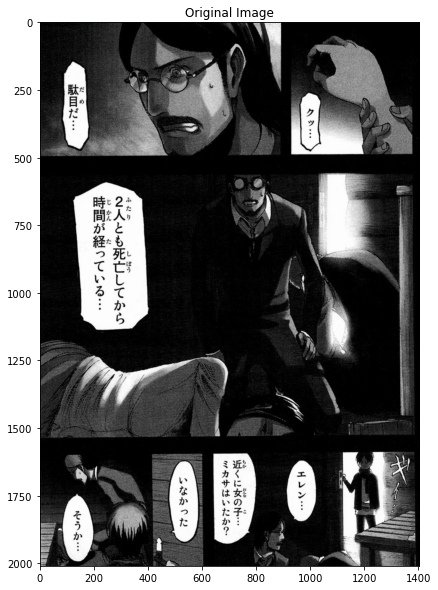

In [230]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from Segmentation import segmented_sentence
import speechbubbles
from sklearn.preprocessing import LabelEncoder
import Dictionary as d
from random import sample


image = cv2.imread('page.png')
plt.figure(figsize=(15,10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.show()

## Finding the Speech Bubbles

First we must extract the text from the image. For this we have used some image processing and contours to isolate the speech bubbles. Then we clean up the images till only the text remains.
The details of the implementation are in the notebook speechbubbles.

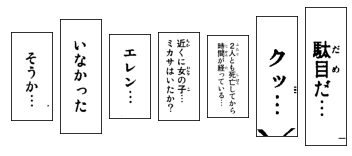

In [231]:
bubble=speechbubbles.find_bubbles(image)
bubbles=[]
for b in bubble:
    bubbles.append(cv2.bitwise_not(speechbubbles.to_rect(b)))
for i in range(7):
    plt.subplot(1,7,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(bubbles[i], cmap=plt.cm.binary)
plt.show()

## Segementation

Once we have the text, we break it down into individual characters. For this we have used the **histogram projection method**.
Some things to keep in mind are
1. Japanese is read right to left, and top to bottom
2. We do not want to read the Furigana, which is the pronounciation mentioned next to the Kanji characters

The details can be found in the notebook Segmentation

In [232]:
char=[]
for bubble in bubbles:
    char.append(segmented_sentence(bubble))

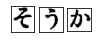

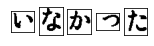

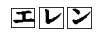

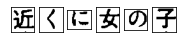

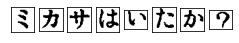

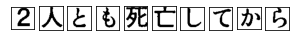

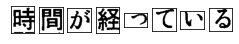

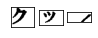

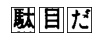

In [233]:
for i in range(7):
    for j in range(len(char[i])):
        for k in range(len(char[i][j])):
            plt.subplot(len(char[i]),12,k+1)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            plt.imshow(char[i][j][k], cmap=plt.cm.binary)            
        plt.show()
        

(we also end up extracting some of the background. oops)

# OCR

## DATA

To train our model, we will be using the ETL Character Database which can be found at http://etlcdb.db.aist.go.jp/

Japanese has three scripts
1. Katakana- 48 characters found in ETL1
2. Hiragana- 71 characters found in ETL8
3. Kanji- 883 characters found in ETL8
For each of these we consider samples from 160 writers. The data also includes upper case A-Z, 0-9 and some special symbols

Some samples from the data are

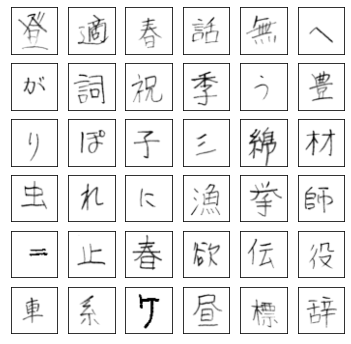

In [234]:
data=np.load('data.npz')['arr_0'].reshape([-1, 48,48])
ix=sample(range(0,data.shape[0]-1),100)
data=data[ix]
plt.figure(figsize=(6,6))
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(data[i], cmap=plt.cm.binary)      
plt.show()


The key for the labels for the characters can be found in the file dictionary.py
The following function returns the character from the label

In [235]:
def to_letter(x):
    try:
        if x<=92:
            return chr(x)
        if x<222:
            return d.katakana[x-177]
        return d.JIS0208[x]
    except:
        return '?'

## Model

We use a convolutional neural network to classify the images. The details are in the notebook "training the model".
Using 20% of the data as we get 0.9673 training accuracy and 0.9684 validation accuracy

In [236]:
model = keras.models.load_model('my_model')

In [237]:
encoder = LabelEncoder()
encoder.classes_ = np.load('classes.npy')

## Recognizing characters

In [238]:
##preprocessing charcters before passing to the model
kernel=np.ones((2,2), np.uint8)
for i in range(7):
    for j in range(len(char[i])):
        for k in range(len(char[i][j])):
            char[i][j][k]=cv2.copyMakeBorder(char[i][j][k],10,10,10,10,cv2.BORDER_CONSTANT,value=(0,0,0))            
            char[i][j][k]=cv2.resize(char[i][j][k], (48,48), interpolation= cv2.INTER_AREA)
            char[i][j][k]=cv2.erode(char[i][j][k],kernel, iterations=1)
            

In [239]:
X1=[]
for bubble in char:
    X2=[]
    for row in bubble:
        Y_pred = model.predict(np.array(row).reshape([-1,48,48]))
        y_classes = Y_pred.argmax(axis=-1)
        l=list(encoder.inverse_transform(y_classes))
        X2.append(l)
    X1.append(X2)
        

1/1 [==============================] - 0s 23ms/step


In [240]:
for bubble in X1:
    for row in bubble:
        letter=[]
        for char in row:
            letter.append(to_letter(char))
        print(letter)
    print()

['く', 'う', 'か']

['い', 'な', 'か', 'つ', 'た']

['土', 'と', 'ゃ']

['近', 'く', 'に', '五', 'の', '予']
['ら', '力', 'せ', 'は', 'い', 'た', 'か', '夕']

['と', '人', 'と', 'も', '死', 'せ', 'し', 'て', '力', 'ら']
['時', '問', 'か', '程', 'つ', 'て', 'い', '名']

['久', 'り', '記']

['転', '目', 'だ']



We can see that the data performs decently for kanji and hiragana characters but isn't that good with katakana

However processing our images differently leads to better performance with Katakana characters at the cost of Kanji characters

In [241]:
char=[]
for bubble in bubbles:
    char.append(segmented_sentence(bubble))
    
kernel=np.ones((2,2), np.uint8)
for i in range(7):
    for j in range(len(char[i])):
        for k in range(len(char[i][j])):
            char[i][j][k]=cv2.copyMakeBorder(char[i][j][k],10,10,10,10,cv2.BORDER_CONSTANT,value=(0,0,0))            
            char[i][j][k]=cv2.resize(char[i][j][k], (48,48), interpolation= cv2.INTER_AREA)
            #char[i][j][k]=cv2.erode(char[i][j][k],kernel, iterations=1)
            
X1=[]
for bubble in char:
    X2=[]
    for row in bubble:
        Y_pred = model.predict(np.array(row).reshape([-1,48,48]))
        y_classes = Y_pred.argmax(axis=-1)
        l=list(encoder.inverse_transform(y_classes))
        X2.append(l)
    X1.append(X2)

for bubble in X1:
    for row in bubble:
        letter=[]
        for char in row:
            letter.append(to_letter(char))
        print(letter)
    print()


1/1 [==============================] - 0s 22ms/step
['毛', 'う', 'が']

['い', 'な', 'が', 'ゃ', 'た']

['エ', 'レ', 'ン']

['近', 'く', 'ね', '虫', 'の', '予']
['ま', '力', 'サ', 'は', 'い', 'ね', 'が', 'り']

['2', '人', 'も', '6', '勢', 'せ', 'し', 'て', 'か', 'ら']
['ユ', '聞', 'が', '雑', 'つ', 'て', 'レ', '名']

['夕', '少', 'ん']

['厳', '目', 'だ']



Further using the same model but trained after modifying the etl1 data using thresholding, gives us a model that predicts katakana really well but doesn't do good with the rest at all!

In [242]:
model1 = keras.models.load_model('my_model_1')
encoder1 = LabelEncoder()
encoder1.classes_ = np.load('classes_1.npy')

In [243]:
char=[]
for bubble in bubbles:
    char.append(segmented_sentence(bubble))
    
kernel=np.ones((2,2), np.uint8)
for i in range(7):
    for j in range(len(char[i])):
        for k in range(len(char[i][j])):
            char[i][j][k]=cv2.copyMakeBorder(char[i][j][k],10,10,10,10,cv2.BORDER_CONSTANT,value=(0,0,0))            
            char[i][j][k]=cv2.resize(char[i][j][k], (48,48), interpolation= cv2.INTER_AREA)
            char[i][j][k]=cv2.erode(char[i][j][k],kernel, iterations=1)
            
X1=[]
for bubble in char:
    X2=[]
    for row in bubble:
        Y_pred = model1.predict(np.array(row).reshape([-1,48,48]))
        y_classes = Y_pred.argmax(axis=-1)
        l=list(encoder1.inverse_transform(y_classes))
        X2.append(l)
    X1.append(X2)

for bubble in X1:
    for row in bubble:
        letter=[]
        for char in row:
            letter.append(to_letter(char))
        print(letter)
    print()

1/1 [==============================] - 0s 14ms/step
['モ', 'ラ', 'カ']

['.', 'セ', 'カ', 'ヘ', 'カ']

['エ', 'レ', 'ン']

['エ', ')', 'ヒ', 'セ', 'Q', 'チ']
['ミ', 'カ', 'サ', 'ロ', 'セ', 'カ', 'カ', 'ワ']

['2', 'ス', 'ヒ', '6', '死', 'ヒ', 'L', 'マ', 'カ', 'S']
['時', '聞', 'カ', '経', 'ヘ', 'マ', 'V', 'Z']

['ク', 'ツ', 'ノ']

['職', 'B', 'セ']



The model could be impoved by using data that is more consistent between the types of characters